# Explore

This file demonstrates the code

In [1]:
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
Numpy Version 1.21.5
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import line_profiler
import memory_profiler

np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

In [195]:
from Scripts.generate_data import generate_Ys
from Scripts.scBiGLasso import scBiGLasso
from Scripts.anBiGLasso import anBiGLasso
from Scripts.utilities import generate_confusion_matrices
from Scripts.utilities import precision, recall, accuracy

## Explore Results
How good is it?  Does it work like we expect?

In [307]:
# Standard way to generate matrix variate data
Psi_gen, Theta_gen, Ys = generate_Ys(
    m=(m:=100),
    n=(n:=4),
    p=(p:=5),
    expected_nonzero_psi=n**2 / 5,
    expected_nonzero_theta=p**2 / 5,
    structure="Kronecker Sum"
)
Ys.shape

(100, 4, 5)

In [180]:
Psi, Theta = scBiGLasso(
    N = 100,
    eps = 10e-4,
    Ys = Ys,
    beta_1 = 0, #For perfect precision: .4 for Kron Prod, .7 for Kron Sum
    beta_2 = 0,
    verbose = True
)
print("===Psi===")
print(Psi_cm := generate_confusion_matrices(Psi, Psi_gen, mode='Negative'))
print(
    f"{precision(Psi_cm)=:.3f}",
    f"\n{recall(Psi_cm)=:.3f}",
    f"\n{accuracy(Psi_cm)=:.3f}"
)
print("\n==Theta==")
print(Theta_cm := generate_confusion_matrices(Theta, Theta_gen, mode='Negative'))
print(
    f"{precision(Theta_cm)=:.3f}",
    f"\n{recall(Theta_cm)=:.3f}",
    f"\n{accuracy(Theta_cm)=:.3f}"
)

Iter=0: NLL=32.28578, w/ Lasso: 32.28578
Just Psi: NLL=16.44287, w/ Lasso: 16.44287
Just Theta: NLL=15.84292, w/ Lasso: 15.84292
-------
Iter=1: NLL=32.25458, w/ Lasso: 32.25458
Just Psi: NLL=16.41920, w/ Lasso: 16.41920
Just Theta: NLL=15.83538, w/ Lasso: 15.83538
-------
Iter=2: NLL=32.29388, w/ Lasso: 32.29388
Just Psi: NLL=16.44647, w/ Lasso: 16.44647
Just Theta: NLL=15.84741, w/ Lasso: 15.84741
-------
Iter=3: NLL=32.29393, w/ Lasso: 32.29393
Just Psi: NLL=16.44645, w/ Lasso: 16.44645
Just Theta: NLL=15.84748, w/ Lasso: 15.84748
-------
Iter=4: NLL=32.29505, w/ Lasso: 32.29505
Just Psi: NLL=16.44729, w/ Lasso: 16.44729
Just Theta: NLL=15.84776, w/ Lasso: 15.84776
-------
Early convergence on iteration 4!
===Psi===
[[ 2. 54.]
 [12. 22.]]
precision(Psi_cm)=0.036 
recall(Psi_cm)=0.143 
accuracy(Psi_cm)=0.267

==Theta==
[[ 0. 46.]
 [ 2. 24.]]
precision(Theta_cm)=0.000 
recall(Theta_cm)=0.000 
accuracy(Theta_cm)=0.333


In [248]:
Psi, Theta = anBiGLasso(
    Ys = Ys,
    beta_1 = 0.001,
    beta_2 = 0.001,
)
print("===Psi===")
print(Psi_cm := generate_confusion_matrices(Psi, Psi_gen, mode='Negative'))
print(
    f"{precision(Psi_cm)=:.3f}",
    f"\n{recall(Psi_cm)=:.3f}",
    f"\n{accuracy(Psi_cm)=:.3f}"
)
print("\n==Theta==")
print(Theta_cm := generate_confusion_matrices(Theta, Theta_gen, mode='Negative'))
print(
    f"{precision(Theta_cm)=:.3f}",
    f"\n{recall(Theta_cm)=:.3f}",
    f"\n{accuracy(Theta_cm)=:.3f}"
)

===Psi===
[[  80.  148.]
 [  46. 1286.]]
precision(Psi_cm)=0.351 
recall(Psi_cm)=0.635 
accuracy(Psi_cm)=0.876

==Theta==
[[  76.  148.]
 [ 128. 1208.]]
precision(Theta_cm)=0.339 
recall(Theta_cm)=0.373 
accuracy(Theta_cm)=0.823


In [181]:
# Set betas to zero in previous equation
# Then we can show that scBiGLasso really does
# learn the MLE; its eigenvectors match up!
from Scripts.utilities import tr_p, K, kron_sum
from Scripts.anBiGLasso import eigenvectors_MLE
from Scripts.anBiGLasso import eigenvalues_MLE


trpW = tr_p(kron_sum(Psi, Theta), p=p)
trpW_true = tr_p(kron_sum(Psi_gen, Theta_gen), p=p)
swtrnW = tr_p(kron_sum(Theta, Psi), p=n)
T = np.einsum("mnp, mlp -> nl", Ys, Ys) / (m*p)
S = np.einsum("mnp, mnl -> pl", Ys, Ys) / (m*n)
_T = T * K(n, 2*p-1, p)
_S = S * K(p, 2*n-1, n)

print("True first evec:")
print(np.linalg.eigh(Psi_gen)[1][0])

print("True trpW first evec:")
print(np.linalg.eigh(trpW_true)[1][0])

# We can see that we do indeed get correct evecs from trpW
print("scBiGLasso first evec:")
print(np.linalg.eigh(Psi)[1][0])

print("scBiGLasso trpW first evec:")
print(np.linalg.eigh(trpW)[1][0])

# But it is not estimated right...
print("anBiGLasso first evec:")
print(eigenvectors_MLE(T, S)[0][0])

# What about eigenvalues?
# Eigenvalue estimate is pretty good!
# Provided we supply it with the true eigenvectors
print("True eigs:")
print(np.sort(np.linalg.eigh(Psi_gen)[0]))

print("scBiGLasso eigs:")
print(np.sort(np.linalg.eigh(Psi_gen)[0]))

print("anBiGLasso eigs with true evecs:")
print(np.sort(eigenvalues_MLE(
    Ys,
    np.linalg.eigh(Psi_gen)[1],
    np.linalg.eigh(Theta_gen)[1]
)[0]))

print("anBiGLasso eigs with scBiGLasso evecs:")
print(np.sort(eigenvalues_MLE(
    Ys,
    np.linalg.eigh(Psi)[1],
    np.linalg.eigh(Theta)[1]
)[0]))

print("anBiGLasso eigs with anBiGLasso evecs:")
print(np.sort(eigenvalues_MLE(
    Ys,
    *eigenvectors_MLE(T, S)
)[0]))

True first evec:
[ 0.147  0.703 -0.    -0.356  0.    -0.     0.     0.     0.002 -0.598]
True trpW first evec:
[ 0.147  0.703 -0.    -0.356  0.    -0.    -0.     0.     0.002 -0.598]
scBiGLasso first evec:
[-0.529  0.239  0.035  0.298 -0.051  0.359 -0.105  0.426 -0.308 -0.391]
scBiGLasso trpW first evec:
[-0.529  0.239  0.035  0.298 -0.051  0.359 -0.105  0.426 -0.308 -0.391]
anBiGLasso first evec:
[-0.64   0.242  0.172  0.229  0.308 -0.095  0.122  0.474  0.156  0.286]
True eigs:
[0.82  0.858 0.911 0.921 0.952 1.006 1.014 1.017 1.159 1.344]
scBiGLasso eigs:
[0.82  0.858 0.911 0.921 0.952 1.006 1.014 1.017 1.159 1.344]
anBiGLasso eigs with true evecs:
[0.686 0.83  0.883 0.911 0.974 0.996 1.003 1.022 1.151 1.242]
anBiGLasso eigs with scBiGLasso evecs:
[0.502 0.757 0.824 0.832 0.884 1.021 1.124 1.143 1.175 1.578]
anBiGLasso eigs with anBiGLasso evecs:
[0.518 0.725 0.829 0.846 0.919 0.988 1.074 1.109 1.286 1.555]


In [13]:
print(E1 := np.linalg.eigh(Psi)[1])
print(E2 := eigenvectors_MLE(
    np.einsum("mpn, mpl -> nl", Ys, Ys) / (m*p),
    np.einsum("mpn, mln -> pl", Ys, Ys) / (m*n)
)[0])
print(E1 @ E2.T)

[[ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.213 -0.167  0.11  ... -0.163  0.038  0.227]
 [-0.039 -0.073 -0.019 ... -0.018  0.053  0.066]
 ...
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [-0.029 -0.142  0.034 ...  0.128  0.061  0.213]
 [-0.324 -0.033 -0.068 ... -0.301 -0.092  0.113]]
[[-0.009  0.011 -0.022 ... -0.047  0.051 -0.011]
 [-0.067 -0.064 -0.055 ... -0.238  0.136 -0.135]
 [-0.199 -0.119 -0.06  ...  0.091 -0.083 -0.086]
 ...
 [-0.005 -0.024  0.004 ... -0.024  0.002 -0.014]
 [ 0.052  0.006  0.157 ...  0.072  0.06  -0.051]
 [-0.053  0.014  0.057 ...  0.308  0.03   0.274]]
[[ 0.116 -0.223  0.059 ... -0.071 -0.023 -0.049]
 [-0.119  0.119 -0.096 ...  0.043 -0.112 -0.077]
 [-0.072  0.148 -0.137 ... -0.073  0.161 -0.02 ]
 ...
 [ 0.067  0.097 -0.105 ... -0.066 -0.013  0.1  ]
 [ 0.036 -0.    -0.084 ... -0.022  0.124  0.073]
 [-0.024 -0.008 -0.005 ... -0.01  -0.123  0.052]]


## Explore Performance
How fast is it?  How much memory does it use?

<font size=-1>_You have to run these cells yourself to see results_</font>

In [218]:
# Time to generate data
from Scripts.generate_data import matrix_normal_ks
kwargs_gen = {
    'm': 100,
    'p': (p:=100),
    'n': (n:=100),
    'structure': 'Kronecker Sum',
    'expected_nonzero_psi': n**2 / 5,
    'expected_nonzero_theta': p**2 / 5
}
%lprun -f generate_Ys -f matrix_normal_ks generate_Ys(**kwargs_gen)

In [226]:
# Time to run scBiGLasso
from Scripts.scBiGLasso import _scBiGLasso_internal, _calculate_A
from Scripts.utilities import LASSO

kwargs = {
    "N": 100,
    "eps": 10e-3,
    "Ys": Ys,
    "beta_1": 0.7,
    "beta_2": 0.7
}
%lprun -f scBiGLasso -f _scBiGLasso_internal -f LASSO -f _calculate_A scBiGLasso(**kwargs)

In [306]:
from Scripts.anBiGLasso import calculateEigenvalues
kwargs = {
    "Ys": Ys,
    "beta_1": 0.0006,
    "beta_2": 0.0006
}
%lprun -f anBiGLasso -f eigenvectors_MLE -f eigenvalues_MLE -f calculateEigenvalues anBiGLasso(**kwargs)

In [9]:
# Info on memory usage
# Honestly, the results don't seem useful?
%mprun -f scBiGLasso -f _scBiGLasso_internal -f LASSO_sklearn -f _calculate_A scBiGLasso(**kwargs)

# Explore Results
How does it do for different $\beta$?  For different densities?

<font size=-1>_(May take a while to run)_</font>

In [183]:
from Scripts.experiments import create_precision_recall_curves

In [316]:
# How does choice of betas and matrix size affect results?
sizes = [20, 40, 60, 80, 100]
betas = [
    10**np.arange(-2, 0, 0.05), # 20
    10**np.arange(-2, 0, 0.05), # 40
    10**np.arange(-1, 1, 0.05), # 60
    10**np.arange(-1, 1, 0.1), # 80
    10**np.arange(-1, 1, 0.1) # 100
]
interesting_indices = [
    [2, 16, 24],
    [2, 16, 24],
    [2, 12, 16],
    [2, 6, 10],
    [2, 6, 10, 14]
]
vary_sizes_experiment = dict({})
for idx, size in enumerate(sizes):
    fig, axs, dicts = create_precision_recall_curves(
        betas[idx],
        100,
        size,
        attempts=25,
        indices_to_highlight=interesting_indices[idx]
    )
    vary_sizes_experiment[size] = dicts
    #fig.savefig(f'../Plots/Vary-Sizes-Experiment/Precision-Recall-Vary-Sizes-{size}')
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure
#np.save('../Data/Vary-Sizes-Experiment/Precisions-and-Recalls.npy', vary_sizes_experiment) 
    
# Obeservation: the larger the size, the more 'stable' the results are, as in
# the precision-recall curve is smoother

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/baileyandrew/opt/anaconda3/envs/my_default_environment/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_3747/3216551174.py", line 19, in <cell line: 18>
    fig, axs, dicts = create_precision_recall_curves(
  File "/Users/baileyandrew/Desktop/Python Notebooks.nosync/Research/scBiGLasso Implementation/Python Implementation/Scripts/experiments.py", line 141, in create_precision_recall_curves
    Psi_cms, Theta_cms = get_cms_for_betas(
  File "/Users/baileyandrew/Desktop/Python Notebooks.nosync/Research/scBiGLasso Implementation/Python Implementation/Scripts/experiments.py", line 43, in get_cms_for_betas
    Psi, Theta = scBiGLasso(
  File "/Users/baileyandrew/Desktop/Python Notebooks.nosync/Research/scBiGLasso Implementation/Python Implementation/Scripts/scBiGLasso.py", line 210, in 

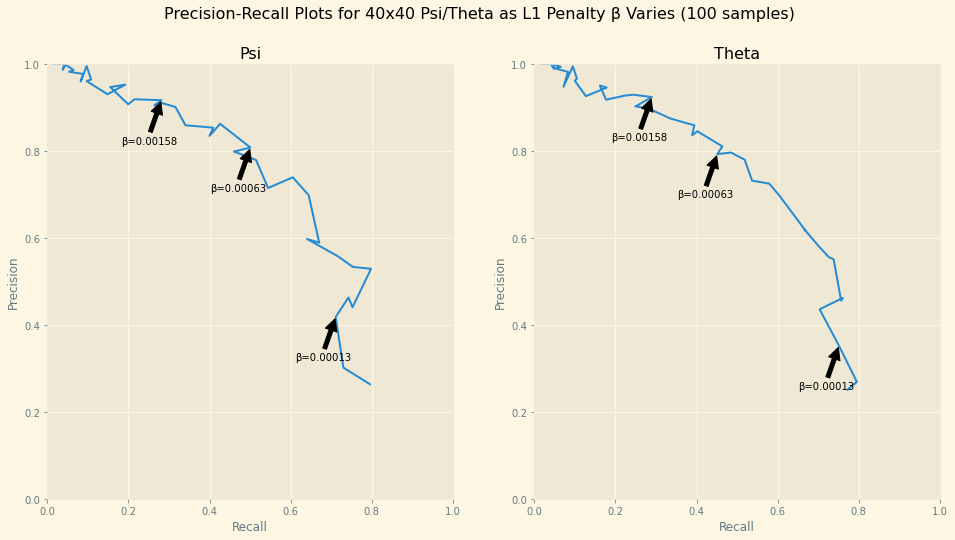

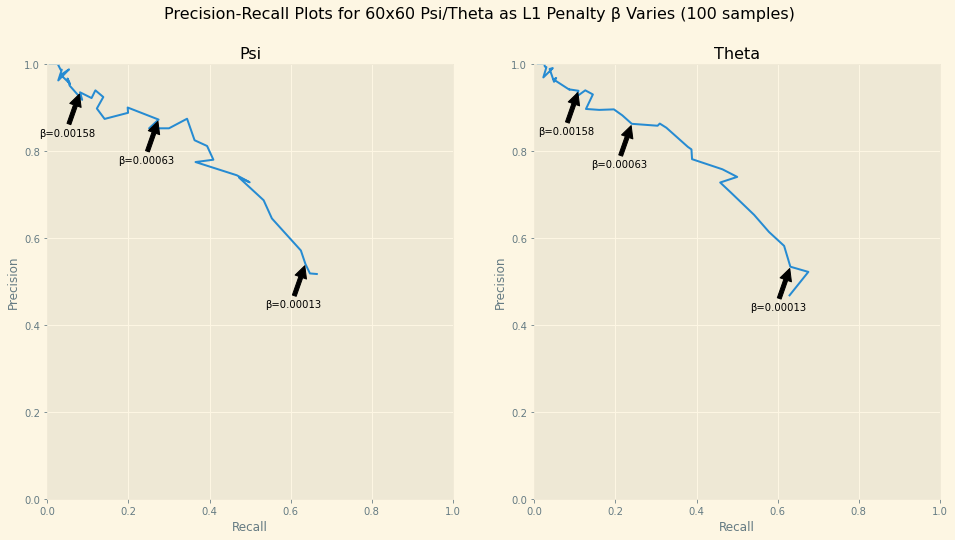

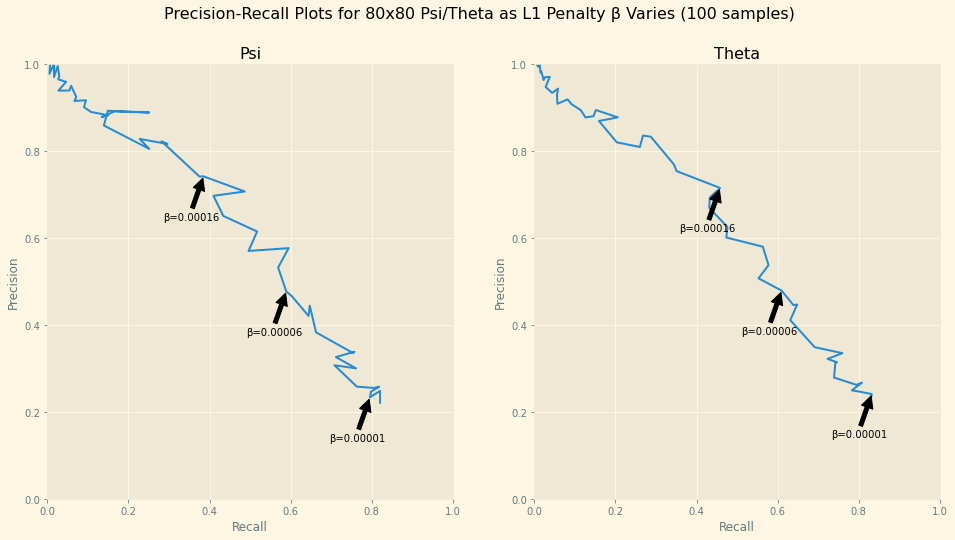

In [315]:
# How does choice of betas and matrix size affect results?
# =================== for anBiGLasso ================
sizes = [40, 60, 80]#, 100, 120]
betas = [
    10**np.arange(-4, -1, 0.05), # 40
    10**np.arange(-4, -1, 0.05), # 60
    10**np.arange(-5, -2, 0.05), # 80
    10**np.arange(-5, -2, 0.05), # 100
    10**np.arange(-5, -2, 0.05), # 120
]
interesting_indices = [
    [2, 16, 24],
    [2, 16, 24],
    [2, 16, 24],
    [2, 16, 24],
    [2, 16, 24]
]
#vary_sizes_experiment = dict({})
for idx, size in enumerate(sizes):
    fig, axs, dicts = create_precision_recall_curves(
        betas[idx],
        100,
        size,
        attempts=25,
        indices_to_highlight=interesting_indices[idx],
        alg="anBiGLasso"
    )
    #vary_sizes_experiment[size] = dicts
    #fig.savefig(f'../Plots/Vary-Sizes-Experiment/Precision-Recall-Vary-Sizes-{size}')
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure
#np.save('../Data/Vary-Sizes-Experiment/Precisions-and-Recalls.npy', vary_sizes_experiment) 

# If we generate data from invwishart with the degrees-of-freedom parameter equal
# to the size of the data, results are worse than if the degrees-of-freedom is larger.
# Currently its set to do the worst.
# (Well, I don't think the alg actually does worse on average, it just has a
# notably higher variance.)

In [81]:
samples = [1, 2, 5, 10, 20, 50, 100]
vary_samples_experiment = dict({})
for idx, sample in enumerate(samples):
    fig, axs, dicts = create_precision_recall_curves(
        10**np.arange(-1, 1, 0.05),
        sample,
        50,
        attempts=25,
        indices_to_highlight=[2, 12, 16, 24],
        verbose=False
    )
    vary_sizes_experiment[sample] = dicts
    fig.savefig(f'../Plots/Vary-Samples-Experiment/Precision-Recall-Vary-Samples-{sample}')
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure
np.save('../Data/Vary-Samples-Experiment/Precisions-and-Recalls.npy', vary_sizes_experiment) 

# Observation: it seems like low sample counts take longer to converge

KeyboardInterrupt: 